In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, GridSearchCV
%matplotlib inline
import math as m
import scipy.stats
pd.set_option("display.precision", 8)

def indexlist(data,):
    '''use indeces to mark the 143 gps coordinates'''
    checklist = data['ref_x'].unique()
    for i in range(len(checklist)):
        data['point_index'] = data['point_index'].replace([checklist[i]],int(i))
    return data

def wknn_manhattan(data,k=10,state=101):
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:8],data.iloc[:,-1],
                                                        test_size=0.20,random_state=state)
    pred_rec = []
    for i in range(len(y_test)):
        #get the norm-1 distance
        weighted_distances = np.dot(np.abs(X_train - X_test.iloc[i]),w_rec)
        nn_ids = weighted_distances.argsort()[:k]
        nn_index = y_train.iloc[nn_ids]
        predi = int(scipy.stats.mode(nn_index)[0][0])
        pred_rec.append(predi)
    return np.array([pred_rec]),np.array([y_test])    

def wknn_reg_manhattan(data,k=17,state=101):
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:8],data.iloc[:,-1],
                                                        test_size=0.20,random_state=state)
    test = gps.iloc[y_test.index]
    test_ = np.array(list(zip(test.ref_x, test.ref_y)))
    pred_rec = []
    for i in range(len(y_test)):
        #get the norm-1 distance
        weighted_distances = np.dot(np.abs(X_train - X_test.iloc[i]),w_rec)
        nn_ids = weighted_distances.argsort()[:k]
        nn_index = y_train.iloc[nn_ids]
        indeces = nn_index.value_counts().index[:4]
        counts = nn_index.value_counts().values[:4]
        try:
            values = []
            for i in range(4):
                values.append(np.array(checklist.iloc[int(indeces[i])][0]))
            values = np.array(values)
            pred_i = np.dot(values.T,counts.T)/counts.sum()
        # if the location number < 3, choose the location with the highest counts
        except:
            pred_i = checklist.iloc[int(indeces[0])][0]
        pred_rec.append(pred_i)
    pred_ = np.array(pred_rec)
    se_rec = []
    for i in range(len(test)):
        lon_pred, lat_pred = pred_[i]
        lon_, lat_ = test_[i]
        err_lon = lon_pred - lon_
        err_lat = lat_pred -lat_
        err_x = err_lon*((40000/360)*1000*m.cos(lat_pred))
        err_y = err_lat*((40000/360)*1000)
        se = err_x**2 + err_y**2
        se_rec.append(se)
    return se_rec

def error_record(y_p,y_,checklist,se_rec):
    lon_pred, lat_pred = checklist.iloc[y_p][0]
    lon_, lat_ = checklist.iloc[y_][0]
    err_lon = lon_pred - lon_
    err_lat = lat_pred -lat_
    err_x = err_lon*((40000/360)*1000*m.cos(lat_pred))
    err_y = err_lat*((40000/360)*1000)
    se = err_x**2 + err_y**2
    se_rec.append(se)

def result_report(se_rec,test):
    rmse = np.sqrt(sum(se_rec)/len(test))
    print("RMSE is {:.2f}m".format(rmse))
    a = np.sqrt(se_rec)
    #reshape b from (1,1116) to (1116)
    b = np.sort(a.T).flatten()
    print("When the accuracy is 80%,RMSE is {:.2f}m".format(b[int(len(a)*0.8)]))

def give_result():
    se_rec = []
    pred = np.array(result.pred)
    test = np.array(result.test)
    for i in range(len(result.test)):
        y_ = int(test[i])
        y_p = int(pred[i])
        if y_ == y_p:
            se = 0
            se_rec.append(se)
        else:
            error_record(y_p,y_,checklist,se_rec)
    result_report(se_rec,test)

In [2]:
#read files
rsrp = pd.read_csv('rds-SRSRP.csv')
gps = pd.read_csv("gps.csv")
gps['coordinate'] =  list(zip(gps.ref_x, gps.ref_y))
#input indeces for each individual gps coordinates
gps['point_index'] = gps['ref_x']
gps = indexlist(gps)
checklist = pd.DataFrame(gps.coordinate.unique(),columns = ['coordinate'])
X_train, X_test, y_train, y_test = train_test_split(rsrp,gps['point_index'],
                                                        test_size=0.20,random_state=101)

# get the correlation coefficient of the 8 APs
cc = np.corrcoef(X_train.T)
w_rec = []
for i in range(8):
    cci = cc[i]
    w_rec.append(1/np.dot(cci,cci.T))

#cluster by the largest value
data = pd.read_csv('rds-SRSRP.csv').set_axis([0,1,2,3,4,5,6,7], axis=1)
rsrp['cluster'] = data.idxmax(axis = 1).values
feature = pd.concat([rsrp, gps['point_index']],axis = 1)

In [14]:
#wknn with clustering
result = pd.DataFrame(columns = ['pred','test'])
for i in range(8):
    data_sub = feature[feature['cluster']==i]
    value = data_sub.iloc[:,:8]
    label = data_sub.iloc[:,-1]
    prediction,test = wknn_manhattan(data_sub,k=1)
    df = np.append(prediction,test,axis=0)
    result = result.append(pd.DataFrame(df.T,columns = ['pred','test']))
print('When k = {}, the accuracy is {:.2f}%'.format(1,np.mean(result.pred==result.test)*100))
give_result()

When k = 1, the accuracy is 41.13%
RMSE is 9.52m
When the accuracy is 80%,RMSE is 12.28m


In [22]:
#wknn with clustering find optimal k
acc_rec = []
for j in range(1,21):
    result = pd.DataFrame(columns = ['pred','test'])
    for i in range(8):
        data_sub = feature[feature['cluster']==i]
        value = data_sub.iloc[:,:8]
        label = data_sub.iloc[:,-1]
        prediction,test = wknn_manhattan(data_sub,k=j)
        df = np.append(prediction,test,axis=0)
        result = result.append(pd.DataFrame(df.T,columns = ['pred','test']))
    acc_rec.append(np.mean(result.pred==result.test))
print('When k = {}, the highest accuracy is {:.2f}%'.format(np.argmax(acc_rec)+1,np.max(acc_rec)*100))

When k = 1, the highest accuracy is 41.13%


In [12]:
#wknn regression with clustering
result  = pd.DataFrame(columns = ['error'])
for i in range(8):
    #data0 = feature[feature['rsrp_cluster']==i]
    data_sub = feature[feature['cluster']==i]
    value = data_sub.iloc[:,:8]
    label = data_sub.iloc[:,-1]
    result = result.append(pd.DataFrame(wknn_reg_manhattan(data_sub),columns = ['error']))
rmse = np.sqrt(result.sum()/len(rsrp))[0]
print("RMSE is {:.2f}m".format(rmse))
a = np.sqrt(result)
#reshape b from (1,1116) to (1116)
b = np.sort(a.T).flatten()
print("When the accuracy is 80%,RMSE is {:.2f}m".format(b[int(len(a)*0.8)]))

RMSE is 3.63m
When the accuracy is 80%,RMSE is 9.76m


In [118]:
#wknn regression find optimal k
rmse_rec = []
rse_80_rec = []
for k in range (1,31):
    #wknn regression with clustering
    result  = pd.DataFrame(columns = ['error'])
    for i in range(8):
        #data0 = feature[feature['rsrp_cluster']==i]
        data_sub = feature[feature['cluster']==i]
        value = data_sub.iloc[:,:8]
        label = data_sub.iloc[:,-1]
        result = result.append(pd.DataFrame(wknn_reg_manhattan(data_sub,k),columns = ['error']))
    rmse = np.sqrt(result.sum()/len(rsrp))[0]
    #print("RMSE is {:.2f}m".format(rmse))
    a = np.sqrt(result)
    b = np.sort(a.T).flatten()
    rse_80=b[int(len(a)*0.8)]
    rmse_rec.append(rmse)
    rse_80_rec.append(rse_80)
    #print("When the accuracy is 80%,RMSE is {:.2f}m".format(rmse_80))
print('When k = {}, the lowest RMSE is {:.2f}'.format(np.argmin(rmse_rec)+1,np.min(rmse_rec)))
print("When the accuracy is 80%,RSE is {:.2f}m".format(rse_80_rec[np.argmin(rmse_rec)]))

When k = 15, the lowest RMSE is 3.57
When the accuracy is 80%,RSE is 9.85m


Text(0, 0.5, 'error')

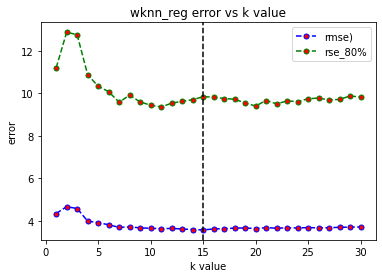

In [125]:
#wknn, plot
plt.plot(range(1,31),rmse_rec,color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=5,label='rmse)')
plt.plot(range(1,31),rmse_80_rec,color='green', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=5,label='rse_80%')
plt.axvline(x = 15,linestyle='dashed',color='black')
plt.legend()
plt.title('wknn_reg error vs k value')
plt.xlabel('k value')

plt.ylabel('error')

In [8]:
# wknn reg. clustering gets the mean RMSE for 20 random states
rmse_rec = []
rse_80_rec = []
for state in range(1,102,5):
    #wknn regression with clustering
    result  = pd.DataFrame(columns = ['error'])
    for i in range(8):
        data_sub = feature[feature['cluster']==i]
        value = data_sub.iloc[:,:8]
        label = data_sub.iloc[:,-1]
        result = result.append(pd.DataFrame(wknn_reg_manhattan(data_sub,k=15,state=state),columns = ['error']))
    rmse = np.sqrt(result.sum()/len(rsrp))[0]
    rmse_rec.append(rmse)
    #reshape b from (1,1116) to (1116)
    a = np.sqrt(result)
    b = np.sort(a.T).flatten()
    rse_80=b[int(len(a)*0.8)]
    rse_80_rec.append(rse_80)
    #print("RMSE is {:.2f}m".format(rmse))
    #print("When the accuracy is 80%,RMSE is {:.2f}m".format(b[int(len(a)*0.8)]))


In [10]:
np.mean(rmse_rec)

9.69438811383905

In [9]:
np.mean(rse_80_rec)

9.69438811383905